In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
from selenium.webdriver.chrome.options import Options
import yfinance as yf
import numpy as np
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common import TimeoutException
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Get today's date

today_date = datetime.today()

today_date = today_date.strftime('%Y_%m_%d')

In [3]:
# # # input the tickers

tickers=['NVDA','AAPL', 'FCX', 'JD', 'META', 'BHP', 'NXE','GOOG']

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['NVDA']: ValueError('Naive time - no tzinfo set')


Empty DataFrame
Columns: [Symbol, Company, Earnings Date, EPS Estimate, Reported EPS, Surprise(%), Earnings Time]
Index: []


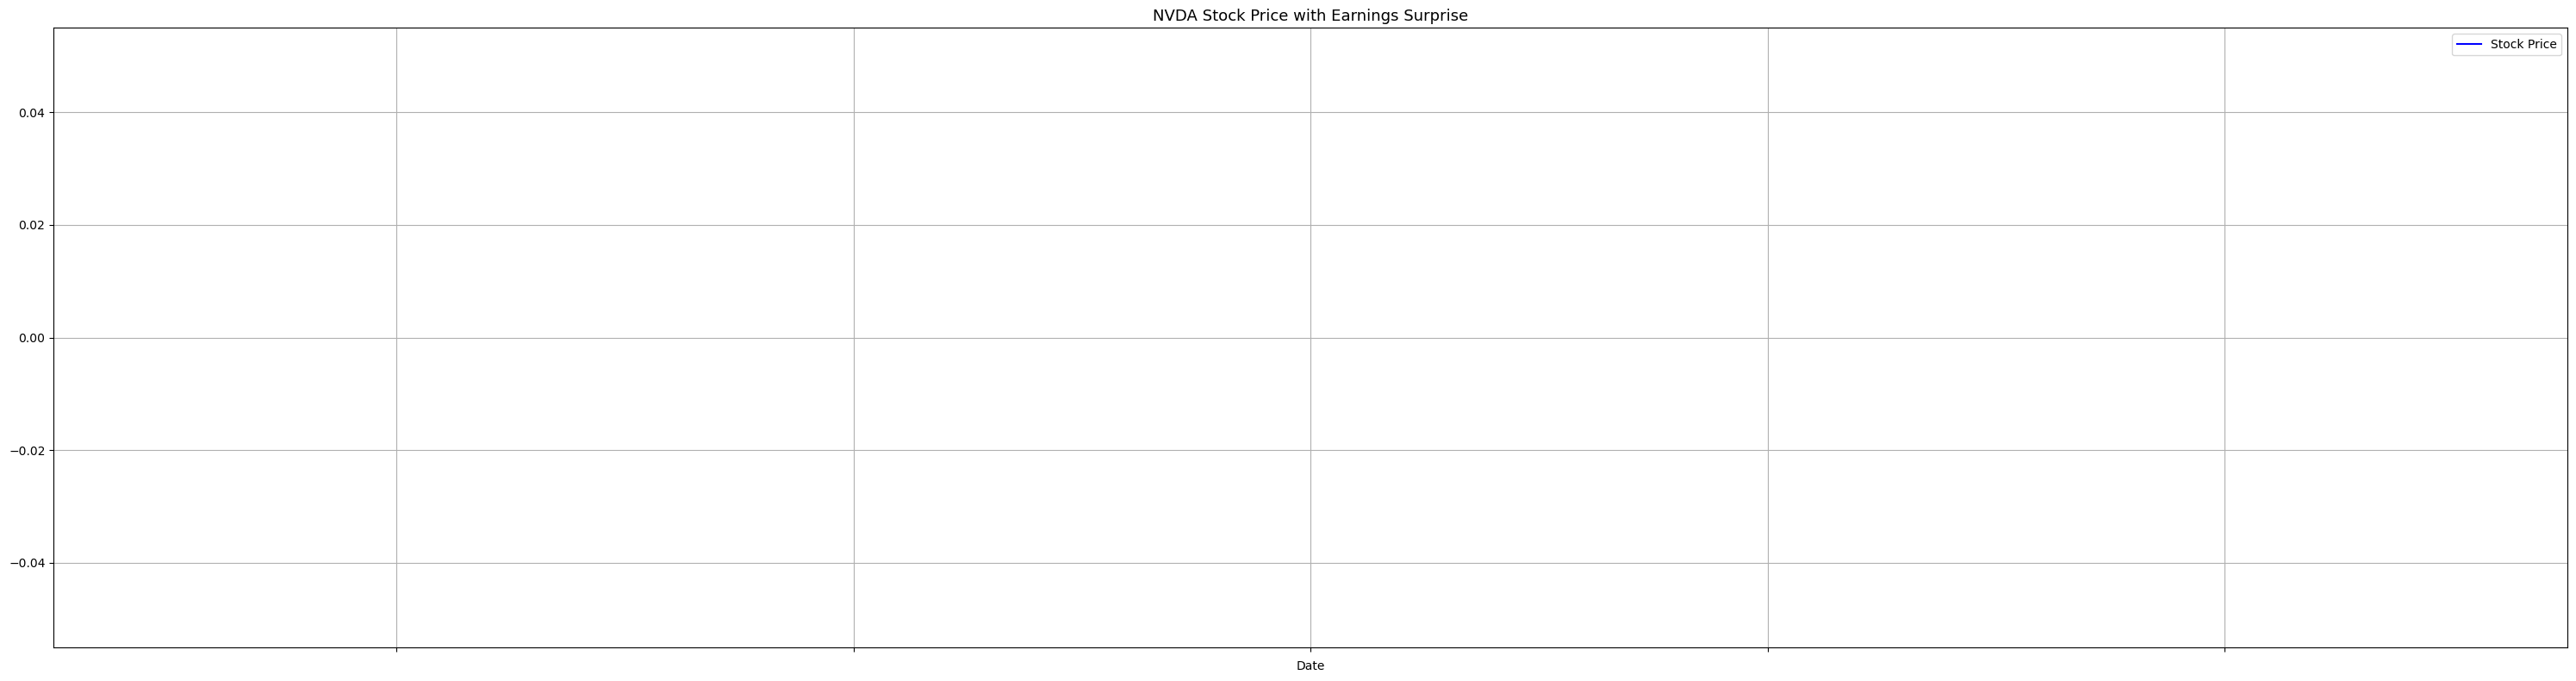

ValueError: not enough values to unpack (expected 4, got 0)

In [21]:
# # # configuration chromedriver
options = Options()
options.headless = True
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--window-size=1920x1080")
driver = webdriver.Chrome(options=options)

for ticker in tickers:
    plots=[]

    # # # create file for the ticker to save plot if doesnt exist yet
    
    import os
    script_dir = os.getcwd()

    folder_name = ticker
    folder_path = os.path.join(script_dir, folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


    

    driver.get(f'https://finance.yahoo.com/calendar/earnings?symbol={ticker}')

    # Remove next line if you are in the US. It accepts the cookies on the pop up page. No pop up page in the US
    WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, '.accept-all'))).click()
    data=[]
    for row in (driver.find_elements(By.XPATH, '//div[@id="fin-cal-table"]//tr')):
        cols = row.find_elements(By.TAG_NAME, 'td')
        cols = [elem.text for elem in cols]
        data.append(cols)


    columns = ['Symbol', 'Company', 'Earnings Date', 'EPS Estimate', 'Reported EPS', 'Surprise(%)']
    earnings_data = pd.DataFrame(data[1:], columns=columns)




    earnings_data=earnings_data[earnings_data['Surprise(%)']!='-']

    # Extract the time and timezone information into a new column
    earnings_data['Earnings Time'] = earnings_data['Earnings Date'].str.extract(r'(\d{1,2} [AP]MEDT)')

    # Extract just the date part from the "Earnings Date" column
    earnings_data['Earnings Date'] = earnings_data['Earnings Date'].str.extract(r'(\b\w+ \d{1,2}, \d{4})')

    # Convert string date to datetime
    earnings_data['Earnings Date'] = pd.to_datetime(earnings_data['Earnings Date'], format='%b %d, %Y')

    # Convert datetime to desired string format
    earnings_data['Earnings Date'] = earnings_data['Earnings Date'].dt.strftime('%Y-%m-%d')

    earnings_data['Surprise(%)'] = earnings_data['Surprise(%)'].str.replace('+', '').astype(float)
    earnings_data=earnings_data[~earnings_data['Surprise(%)'].isnull()]





    print(earnings_data)


    # # # get stock price and ping all the earnings events

    earnings_data['Earnings Date'] = pd.to_datetime(earnings_data['Earnings Date'])


    buffer_days = 10
    startDate = earnings_data['Earnings Date'].min() - pd.Timedelta(days=buffer_days)
    endDate = earnings_data['Earnings Date'].max() + pd.Timedelta(days=buffer_days)

    stock_data = yf.download(ticker, start=startDate, end=endDate)

    plt.figure(figsize=(30, 8))
    stock_data['Close'].plot(label='Stock Price', color='blue')

    # Plotting earnings surprise
    for index, row in earnings_data.iterrows():
        date = row['Earnings Date']
        # If exact date is not available, use the closest available date
        if date not in stock_data.index:
            date=stock_data.index[np.argmin(np.abs(stock_data.index - pd.to_datetime(date)))]
    #         date = stock_data.index[stock_data.index.get_indexer(pd.to_datetime(date), method='nearest')]

        if row['Surprise(%)'] > 0:
            color = 'green'
            marker = '^'
        else:
            color = 'red'
            marker = 'v'

        plt.plot(pd.to_datetime(date), stock_data.loc[date, 'Close'], marker, color=color, markersize=15)

    plt.title(f'{ticker} Stock Price with Earnings Surprise', fontsize = 13 )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    price_earnings_filename = f'{ticker}_{today_date}_price_earnings.png'
    plot_path = os.path.join(folder_path, price_earnings_filename)
    plt.savefig(plot_path)
    plots.append(plot_path)
    plt.show()





    # Function to compute price effect
    def compute_price_effect(earnings_date, stock_data):
        try:
            # For "Price Before", if missing, we use the most recent previous price
            price_before = stock_data.loc[:pd.Timestamp(earnings_date) - pd.Timedelta(days=1), 'Close'].ffill().iloc[-1]

            price_on = stock_data.loc[pd.Timestamp(earnings_date), 'Close']

            # For "Price After", if missing, we use the next available price
            price_after = stock_data.loc[pd.Timestamp(earnings_date) + pd.Timedelta(days=1):, 'Close'].bfill().iloc[0]

            price_effect = ((price_after - price_before) / price_before) * 100
        except (KeyError, IndexError):  # in case the date is missing in the stock_data even after filling
            return None, None, None, None
        return price_before, price_on, price_after, price_effect

    # Apply the function
    earnings_data['Price Before'], earnings_data['Price On'], earnings_data['Price After'], earnings_data['Price Effect (%)'] = zip(*earnings_data['Earnings Date'].apply(compute_price_effect, stock_data=stock_data))

    #earnings_data['Surprise(%)'] = earnings_data['Surprise(%)'].str.replace('+', '').astype(float)
    earnings_data

    # # # look at the influence of earnings data and surprise data on prices

    # Sort the dataframe by 'Earnings Date' in ascending order
    latest_earnings_data = earnings_data.sort_values(by='Earnings Date').tail(14)

    # Setting up the plot
    fig, ax1 = plt.subplots(figsize=(30,8))

    # Bar positions
    positions = range(len(latest_earnings_data ))
    width = 0.25
    r1 = [pos - width for pos in positions]
    r2 = positions
    r3 = [pos + width for pos in positions]

    # Clustered bar plots for prices
    bars1 = ax1.bar(r1, latest_earnings_data ['Price Before'], width=width, label='Price Before', color='blue', edgecolor='grey')
    bars2 = ax1.bar(r2, latest_earnings_data ['Price On'], width=width, label='Price On', color='cyan', edgecolor='grey')
    bars3 = ax1.bar(r3, latest_earnings_data ['Price After'], width=width, label='Price After', color='lightblue', edgecolor='grey')

    # Line plots for Surprise(%) and Price Effect (%)
    ax2 = ax1.twinx()
    ax2.plot(positions, latest_earnings_data ['Surprise(%)'], color='red', marker='o', label='Surprise(%)')
    ax2.plot(positions, latest_earnings_data ['Price Effect (%)'], color='green', marker='o', label='Price Effect (%)')

    # Annotations for the Surprise(%) and Price Effect (%)
    for i, (date, surprise, effect) in enumerate(zip(latest_earnings_data ['Earnings Date'], latest_earnings_data ['Surprise(%)'], latest_earnings_data ['Price Effect (%)'])):
        ax2.annotate(f"{surprise}%", (i, surprise), textcoords="offset points", xytext=(0,10), ha='center', fontsize=16, color='red', fontweight='bold')
        ax2.annotate(f"{effect:.2f}%", (i, effect), textcoords="offset points", xytext=(0,10), ha='center', fontsize=16, color='green', fontweight='bold')

    # Annotations for prices
    def annotate_bars(bars, ax):
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=14, rotation=45)

    annotate_bars(bars1, ax1)
    annotate_bars(bars2, ax1)
    annotate_bars(bars3, ax1)

    # Setting x-axis with better spacing
    ax1.set_xticks(positions)
    ax1.set_xticklabels(latest_earnings_data ['Earnings Date'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=14)

    # Setting labels and title
    ax1.set_xlabel('Earnings Date', fontweight='bold')
    ax1.set_ylabel('Price', fontweight='bold')
    ax2.set_ylabel('Percentage (%)', fontweight='bold')
    ax1.set_title('Earnings Data with Surprise and Price Effect', fontsize=18)

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    surprise_effect_filename = f'{ticker}_{today_date}_surprise_effect_.png'
    plot_path = os.path.join(folder_path, surprise_effect_filename)
    plt.savefig(plot_path)
    plots.append(plot_path)
    plt.show()


    # # # Get the effect of surprise earnings on the price after the earnings


    # Drop rows with NaN values in 'Surprise(%)' and 'Price Effect (%)' columns
    filtered_earnings_data = earnings_data.dropna(subset=['Surprise(%)', 'Price Effect (%)'])

    # Linear regression
    slope, intercept = np.polyfit(filtered_earnings_data['Surprise(%)'], filtered_earnings_data['Price Effect (%)'], 1)
    x = np.array(filtered_earnings_data['Surprise(%)'])
    y_pred = slope * x + intercept

    # Compute r-squared
    correlation_matrix = np.corrcoef(filtered_earnings_data['Surprise(%)'], filtered_earnings_data['Price Effect (%)'])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2

    # Scatter plot with regression line
    plt.figure(figsize=(30, 8))
    plt.scatter(filtered_earnings_data['Surprise(%)'], filtered_earnings_data['Price Effect (%)'], color='blue', marker='o')
    plt.plot(x, y_pred, color='red', label=f'y={slope:.3f}x + {intercept:.3f}')  # regression line
    plt.title(f'Earnings Surprise vs. Price Effect {ticker}', fontsize = 20)
    plt.xlabel('Earnings Surprise(%)')
    plt.ylabel('Price Effect(%)')
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.annotate(f'R-squared = {r_squared:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=15, color='green')
    surprise_vs_price_effect_filename = f'{ticker}_{today_date}_surprise_vs_price_effect.png'
    plot_path = os.path.join(folder_path, surprise_vs_price_effect_filename)
    plt.savefig(plot_path)
    plots.append(plot_path)
    plt.show()

    # # # get the variation in prices around the earnings

    # Define the ticker symbol


    # Check the minimum and maximum earnings dates from the 'df' DataFrame
    min_earnings_date = earnings_data['Earnings Date'].min()
    max_earnings_date = earnings_data['Earnings Date'].max()

    # Get data on this ticker
    stock_data = yf.Ticker(ticker)

    # Get the historical prices for this ticker within the range of earnings dates
    hist = stock_data.history(start=min_earnings_date, end=max_earnings_date)

    # Make the datetime index timezone-naive for compatibility with earnings dates
    hist.index = hist.index.tz_localize(None)

    # Initialize an empty list to hold the price series
    price_series_list = []

    # Extract relevant price data
    for index, row in earnings_data[['Earnings Date']].iterrows():
        print
        earnings_date = pd.to_datetime(row['Earnings Date']).date()

        # Adjust the start date to ensure there's data available for forward-filling
        extended_start_date = earnings_date - timedelta(days=7)  # extending to ensure we have data to forward-fill
        start_date = earnings_date - timedelta(days=5)
        end_date = earnings_date + timedelta(days=5)

        # Select the stock prices for the extended date range
        prices = hist.loc[extended_start_date:end_date, 'Close']

        if prices.empty:
            print(f"No price data available for the range {extended_start_date} to {end_date}. Skipping.")
            continue

        # Forward-fill missing values, this time with available data due to extended range
        all_days = pd.date_range(start=extended_start_date, end=end_date, freq='D')
        prices = prices.reindex(all_days, method='ffill')

        # Truncate the prices Series to only the date range we're interested in (i.e., -5 to +5 days around earnings)
        prices = prices.loc[start_date:end_date]

        # Normalize prices based on the closing price 5 days before earnings
        prices /= prices.iloc[0]

        # Add the series to the list with the days relative to earnings as the new index
        price_series_list.append(prices.reset_index(drop=True))  # reset_index for proper alignment during concatenation

    # Check if the price_series_list is empty
    if not price_series_list:
        raise ValueError("No price data was added to the list. Please check your input data and date ranges.")

    # Concatenate all the series into a single DataFrame
    price_data = pd.concat(price_series_list, axis=1)

    # Correcting the index to represent days relative to earnings
    price_data.index = np.arange(-5, 6)

    # Now, let's plot each series correctly
    plt.figure(figsize=(30, 10))

    # Iterate over each series and plot
    for column in price_data.columns:
        plt.plot(price_data.index, price_data[column])  # Each series represents a different earnings date

    plt.axvline(x=0, color='red', linestyle='--', label='Earnings Date', linewidth=5)
    plt.xticks(np.arange(-5, 6, 1))  # Ensuring the x-axis reflects -5 to +5 days

    # Adding title and labels
    plt.title(f'{ticker} Stock Prices Around Earnings Announcements', fontsize=15)
    plt.xlabel('Days Relative to Earnings', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)

    # Set the tick size
    plt.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size

    #plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')  # Adjusted the legend position so it doesn't overlap the plot
    plt.grid(True)
    prices_around_earnings_filename = f'{ticker}_{today_date}_prices_around_earnings.png'
    plot_path = os.path.join(folder_path, prices_around_earnings_filename)
    plt.savefig(plot_path)
    plots.append(plot_path)
    plt.show()



    # # # get the volatility around the earnings


    # Calculate daily returns
    hist['Returns'] = hist['Close'].pct_change()

    # Calculate 20-day rolling volatility
    hist['20D Volatility'] = hist['Returns'].rolling(window=20).std()


    # Initialize an empty list to hold the volatility series
    volatility_series_list = []

    # Extract relevant volatility data
    for index, row in earnings_data[['Earnings Date']].iterrows():
        earnings_date = pd.to_datetime(row['Earnings Date']).date()
        extended_start_date = earnings_date - timedelta(days=7)
        start_date = earnings_date - timedelta(days=5)
        end_date = earnings_date + timedelta(days=5)

        # Select the volatility for the extended date range
        volatilities = hist.loc[extended_start_date:end_date, '20D Volatility']

        if volatilities.empty:
            print(f"No volatility data available for the range {extended_start_date} to {end_date}. Skipping.")
            continue

        # Forward-fill missing values
        all_days = pd.date_range(start=extended_start_date, end=end_date, freq='D')
        volatilities = volatilities.reindex(all_days, method='ffill')

        # Truncate the volatilities Series to only the date range we're interested in (i.e., -5 to +5 days around earnings)
        volatilities = volatilities.loc[start_date:end_date]

        # Reindex the series to start at 0 on day -5
        volatilities = volatilities - volatilities.iloc[0]

        # Add the series to the list with the days relative to earnings as the new index
        volatility_series_list.append(volatilities.reset_index(drop=True))

    if not volatility_series_list:
        raise ValueError("No volatility data was added to the list. Please check your input data and date ranges.")

    # Concatenate all the series into a single DataFrame
    volatility_data = pd.concat(volatility_series_list, axis=1)

    # Correcting the index to represent days relative to earnings
    volatility_data.index = np.arange(-5, 6)

    # Now, let's plot each series correctly
    plt.figure(figsize=(30, 10))
    for column in volatility_data.columns:
        plt.plot(volatility_data.index, volatility_data[column])  # Each series represents a different earnings date

    plt.axvline(x=0, color='red', linestyle='--', label='Earnings Date', linewidth=5)
    plt.xticks(np.arange(-5, 6, 1))
    plt.title(f'20-Day Rolling Volatility Around Earnings Announcements for {ticker}', fontsize=15)
    plt.xlabel('Days Relative to Earnings', fontsize=12)
    plt.ylabel('20-Day Volatility',fontsize=12)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True)
    vol_around_earnings_filename = f'{ticker}_{today_date}_vol_around_earnings.png'
    plot_path = os.path.join(folder_path, vol_around_earnings_filename)
    plt.savefig(plot_path)
    plots.append(plot_path)
    plt.show()



    # # # get the variation in volume around the earnings


    # Initialize an empty list to hold the volume series
    volume_series_list = []

    # Extract relevant volume data
    for index, row in earnings_data[['Earnings Date']].iterrows():
        earnings_date = pd.to_datetime(row['Earnings Date']).date()
        extended_start_date = earnings_date - timedelta(days=7)
        start_date = earnings_date - timedelta(days=5)
        end_date = earnings_date + timedelta(days=5)

        # Select the volume for the extended date range
        volumes = hist.loc[extended_start_date:end_date, 'Volume']

        if volumes.empty:
            print(f"No volume data available for the range {extended_start_date} to {end_date}. Skipping.")
            continue

        # Forward-fill missing values
        all_days = pd.date_range(start=extended_start_date, end=end_date, freq='D')
        volumes = volumes.reindex(all_days, method='ffill')

        # Truncate the volumes Series to only the date range we're interested in (i.e., -5 to +5 days around earnings)
        volumes = volumes.loc[start_date:end_date]

        # ### START OF REINDEXING ###
        # Reindex the series to start at 0 on day -5
        volumes = volumes - volumes.iloc[0]
        # ### END OF REINDEXING ###

        # Add the series to the list with the days relative to earnings as the new index
        volume_series_list.append(volumes.reset_index(drop=True))

    if not volume_series_list:
        raise ValueError("No volume data was added to the list. Please check your input data and date ranges.")

    # Concatenate all the series into a single DataFrame
    volume_data = pd.concat(volume_series_list, axis=1)

    # Correcting the index to represent days relative to earnings
    volume_data.index = np.arange(-5, 6)


    # Now, let's plot each series correctly
    plt.figure(figsize=(30, 10))
    for column in volume_data.columns:
        plt.plot(volume_data.index, volume_data[column])  # Each series represents a different earnings date

    plt.axvline(x=0, color='red', linestyle='--', label='Earnings Date', linewidth=5)
    plt.xticks(np.arange(-5, 6, 1))
    plt.title(f'Reindexed Volume Around Earnings Announcements for {ticker}',fontsize=15)
    plt.xlabel('Days Relative to Earnings',fontsize=12)
    plt.ylabel('Reindexed Volume',fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True)
    volume_around_earnings_filename = f'{ticker}_{today_date}_volume_around_earnings.png'
    plot_path = os.path.join(folder_path, volume_around_earnings_filename)
    plt.savefig(plot_path)
    plots.append(plot_path)
    plt.show()



    # Open images
    images = [Image.open(plot) for plot in plots]

    # Get the size of each image
    widths, heights = zip(*(img.size for img in images))

    # Calculate the size of the output image
    total_width = max(widths)
    total_height = sum(heights)

    # Create a new blank image with the calculated size
    merged_image = Image.new('RGB', (total_width, total_height))

    # Paste images into the merged image
    y_offset = 0
    for img in images:
        merged_image.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the merged image
    merged_image_filename = f'{ticker}_{today_date}_merged_plots.png'
    merged_image_path = os.path.join(folder_path, merged_image_filename)
    merged_image.save(merged_image_path)

    print(f"Merged image saved as '{merged_image_filename}'")

